In [27]:
# Import required libraries for file handling, image processing, machine learning, and plotting
import os                               # Work with directories and file paths
import cv2                              # OpenCV library for image processing operations
import numpy as np                      # Numerical operations, especially arrays
import matplotlib.pyplot as plt        # Plotting and visualization library
from sklearn.svm import SVC             # Support Vector Machine Classifier for classification task
from sklearn.preprocessing import LabelEncoder  # Encode string labels (e.g., 'add', 'mul') to numeric for training
from skimage.feature import hog, local_binary_pattern  # Feature extraction methods: HOG (shape) and LBP (texture)

# Define OCR class encapsulating all functionality
class AugmentedFeatureOCR:
    def __init__(self):
        # Initialize classifier and label encoder to None (not trained yet)
        self.clf = None
        self.label_encoder = None
        
        # A mapping from symbol class names (keys) to their LaTeX representations (values)
        self.symbol_map = {
            'add': '+', 'sub': '-', 'mul': '×', 'div': '÷',  # Basic math operators
            'eq': '=', 'dec': '.',                            # Equal sign and decimal point
            '0':'0','1':'1','2':'2','3':'3','4':'4','5':'5',  # Digits 0-5 etc.
            '6':'6','7':'7','8':'8','9':'9',
            'x':'x','y':'y','z':'z'                           # Variables as letters
        }

    def augment_image(self, img):
        # Randomly augment input image to increase dataset variability
        
        rows, cols = img.shape  # Get image dimensions (height and width)
        
        # Rotate image by random angle between -10 and 10 degrees
        angle = np.random.uniform(-10, 10)
        M_rot = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)  # Rotation matrix
        img = cv2.warpAffine(img, M_rot, (cols, rows),                 # Apply rotation to image
                             borderMode=cv2.BORDER_CONSTANT, borderValue=0)  # Pad border with black pixels
        
        # Translate image by random shifts in x and y directions (-3 to 3 pixels)
        tx = np.random.uniform(-3, 3)
        ty = np.random.uniform(-3, 3)
        M_trans = np.float32([[1, 0, tx], [0, 1, ty]])  # Translation matrix
        img = cv2.warpAffine(img, M_trans, (cols, rows),
                             borderMode=cv2.BORDER_CONSTANT, borderValue=0)  # Apply translation
        
        # Scale image randomly between 90% and 110% of original size
        scale = np.random.uniform(0.9, 1.1)
        img_resized = cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
        
        desired_size = (64, 64)  # Fixed size output (height, width)
        img_final = np.zeros(desired_size, dtype=np.uint8)  # Blank black canvas for placement
        
        h, w = img_resized.shape[:2]  # Get resized image dimensions
        
        # Calculate coordinates to center resized image in 64x64 canvas
        start_y = max((desired_size[0] - h)//2, 0)
        start_x = max((desired_size[1] - w)//2, 0)
        
        # Crop if resized image larger than 64x64 pixels (to fit)
        img_cropped = img_resized
        if h > desired_size[0] or w > desired_size[1]:
            img_cropped = img_resized[0:desired_size[0], 0:desired_size[1]]
        
        # Place (cropped or original resized) image centered on black canvas
        img_final[start_y:start_y+h, start_x:start_x+w] = img_cropped[:desired_size[0], :desired_size[1]]

        return img_final  # Return the augmented, centered image ready for feature extraction

    def extract_features(self, image):
        # Extract combined HOG and LBP features from input grayscale image
        
        image = cv2.GaussianBlur(image, (3,3), 0)  # Slight blur to reduce noise
        
        # Extract Histogram of Oriented Gradients (HOG)
        hog_feat = hog(image, orientations=9, pixels_per_cell=(8,8),
                       cells_per_block=(2,2), block_norm='L2-Hys', feature_vector=True)
        
        # Extract Local Binary Pattern (LBP) and compute histogram
        lbp = local_binary_pattern(image, P=8, R=1, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)  # Normalize histogram
        
        # Combine HOG and LBP features into one final vector
        features = np.hstack([hog_feat, hist])
        
        # Resize feature vector to fixed length (safety check)
        if features.shape[0] != 1773:
            features = np.resize(features, 1773)
        
        return features  # Return feature vector

    def load_and_augment_dataset(self, data_dir, max_samples=2500, augment_factor=1):
        # Load training images from dataset directory, augment, extract features
        
        # Get list of class folders (each folder typically contains samples for one symbol)
        class_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
        
        features, labels = [], []  # Initialize lists to store features and corresponding labels
        
        # Calculate max samples to load per class to limit dataset size
        samples_per_class = min(175, max_samples // len(class_folders))
        
        for class_name in class_folders:
            class_path = os.path.join(data_dir, class_name)  # Folder for current symbol class
            # Get list of image files, ignore hidden or system files starting with '.'
            img_files = [f for f in os.listdir(class_path) if not f.startswith('.')]
            img_files = img_files[:samples_per_class]  # Limit files per class
            
            loaded_count = 0  # Track how many images loaded for this class
            
            for img_file in img_files:
                img_path = os.path.join(class_path, img_file)  # Full image path
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image as grayscale
                if img is not None:  # Proceed only if image successfully loaded
                    img_resized = cv2.resize(img, (64,64))  # Resize image to fixed size
                    
                    feat = self.extract_features(img_resized)  # Extract features
                    features.append(feat.astype(np.float32))  # Add feature vector to list
                    labels.append(class_name)  # Add corresponding label
                    
                    # Generate augmented images based on augmentation factor
                    for _ in range(augment_factor):
                        aug_img = self.augment_image(img_resized)  # Apply augmentation
                        aug_feat = self.extract_features(aug_img)  # Extract features from augmented image
                        features.append(aug_feat.astype(np.float32))
                        labels.append(class_name)
                    
                    loaded_count += 1  # Increment count of loaded images
            
            print(f"Loaded and augmented {loaded_count} images for class '{class_name}'")
        
        print(f"Total samples after augmentation: {len(features)}")
        
        # Convert list of features into a 2D NumPy array (samples x feature vector length)
        features = np.stack(features, axis=0)
        return features, labels

    def train_classifier(self, X, y):
        # Train SVM classifier given features and labels
        
        self.label_encoder = LabelEncoder()  # Initialize label encoder
        y_encoded = self.label_encoder.fit_transform(y)  # Convert string labels to integers
        self.clf = SVC(kernel='rbf', gamma='scale', probability=True)  # Initialize SVM with RBF kernel
        self.clf.fit(X, y_encoded)  # Train classifier
        print("Training complete!")

    def segment_symbols_fixed(self, image_path, n_symbols):
        # For test images, segment them into fixed-width segments assuming equal symbol widths
        
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load grayscale image
        h, w = img.shape  # Get image dimensions
        symbol_width = w // n_symbols  # Calculate width allocated to each symbol
        
        symbols = []  # List to hold segmented symbol images
        
        for i in range(n_symbols):
            x_start = i * symbol_width  # Starting x pixel for current symbol
            # For last symbol, take remaining width to cover any leftover pixels
            x_end = (i + 1) * symbol_width if i < n_symbols - 1 else w
            symbol = img[:, x_start:x_end]  # Crop symbol column-wise from image
            symbol = cv2.resize(symbol, (64, 64))  # Resize symbol to fixed size
            symbols.append(symbol)  # Store cropped symbol image
        
        return symbols  # Return list of symbol images

    def classify_symbols(self, symbols):
        # Classify each segmented symbol image to predict its class label
        
        predictions = []  # List to store predicted classes
        
        for sym in symbols:
            feat = self.extract_features(sym)  # Extract features for symbol
            pred_encoded = self.clf.predict(feat.reshape(1, -1))  # Predict label index using trained classifier
            pred = self.label_encoder.inverse_transform(pred_encoded)[0]  # Convert label index back to actual class label
            predictions.append(pred)  # Add predicted class to list
        
        return predictions  # Return list of predicted classes

    def to_latex(self, predictions):
        # Convert list of predicted class labels to a LaTeX string using symbol_map dictionary
        
        return " ".join([self.symbol_map.get(p, p) for p in predictions])  # Join mapped symbols with spaces

    def visualize_results(self, symbols, predictions):
        # Plot segmented symbols with their predicted label as title
        
        plt.figure(figsize=(len(symbols)*2.3, 2.5))  # Create figure with width based on number of symbols
        
        for i, sym in enumerate(symbols):
            plt.subplot(1, len(symbols), i+1)  # Create subplot for each symbol
            plt.imshow(sym, cmap='gray')  # Show symbol image in grayscale color map
            plt.title(predictions[i])  # Set subplot title as predicted class
            plt.axis('off')  # Hide axis ticks and labels
        
        plt.tight_layout()
        plt.show()

# Usage example with fixed segmentation and training

data_dir = '/home/radhakrishna/Desktop/dataset'  # Path to your dataset folder

ocr = AugmentedFeatureOCR()  # Create instance of the OCR class
features, labels = ocr.load_and_augment_dataset(data_dir, max_samples=4000, augment_factor=1)  # Load and prepare data
ocr.train_classifier(features, labels)  # Train classifier with extracted features

def test_image_with_gt(test_image_path, true_chars):
    # Test accuracy/functionality on an image with known ground truth characters
    
    print(f"\nTesting image: {test_image_path}")
    print(f"Ground truth characters: {true_chars}")
    
    symbols = ocr.segment_symbols_fixed(test_image_path, len(true_chars))  # Segment image assuming known symbol count
    predicted = ocr.classify_symbols(symbols)  # Predict symbols
    latex = ocr.to_latex(predicted)  # Convert predictions to LaTeX string
    
    print("Predicted characters:", predicted)
    print("Generated LaTeX:", latex)
    
    ocr.visualize_results(symbols, predicted)  # Show segmented symbols with predictions


Loaded and augmented 175 images for class '1'
Loaded and augmented 175 images for class 'dec'
Loaded and augmented 175 images for class 'sub'
Loaded and augmented 175 images for class 'y'
Loaded and augmented 175 images for class '8'
Loaded and augmented 175 images for class 'div'
Loaded and augmented 175 images for class '9'
Loaded and augmented 175 images for class 'z'
Loaded and augmented 175 images for class '5'
Loaded and augmented 175 images for class 'add'
Loaded and augmented 175 images for class 'x'
Loaded and augmented 175 images for class '7'
Loaded and augmented 175 images for class '2'
Loaded and augmented 175 images for class '3'
Loaded and augmented 175 images for class 'mul'
Loaded and augmented 175 images for class 'eq'
Loaded and augmented 175 images for class '6'
Loaded and augmented 175 images for class '4'
Loaded and augmented 175 images for class '0'
Total samples after augmentation: 6650
Training complete!


In [28]:
import random  # Import Python's built-in random module for random choices and sampling

def generate_test_collages_variable_length(data_dir, classes, n_test=50, min_symbols=3, max_symbols=5):
    """
    Generates test images composed of collages with a variable number of symbols side-by-side.
    Each test image contains a horizontal concatenation of randomly chosen symbol images.

    Parameters:
    - data_dir (str): Root directory containing class folders with symbol images
    - classes (list): List of folder names representing symbol classes
    - n_test (int): Number of test collage images to generate
    - min_symbols (int): Minimum number of symbols per generated collage
    - max_symbols (int): Maximum number of symbols per generated collage

    Returns:
    - test_image_info (dict): Dictionary mapping generated image filenames to their ground truth symbol classes (list)
    """
    test_image_info = {}  # Initialize dictionary to store test image names and their symbol class lists

    for i in range(1, n_test+1):  # Generate 'n_test' number of collages
        n_symbols = random.randint(min_symbols, max_symbols)  
        # Randomly choose how many symbols this collage will contain between min_symbols and max_symbols

        chosen = random.sample(classes, n_symbols)  
        # Randomly select 'n_symbols' unique classes from the given list of classes

        chosen_imgs = []  # List to hold loaded and resized symbol images for this collage

        for c in chosen:
            imgs = [f for f in os.listdir(os.path.join(data_dir, c)) if not f.startswith('.')]
            # List all image files in the class directory, ignoring hidden/system files starting with '.'

            img_file = random.choice(imgs)  
            # Randomly select one image file from the available images of this class

            img_path = os.path.join(data_dir, c, img_file)  # Full path for the selected image
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  
            # Read image in grayscale mode

            img = cv2.resize(img, (64, 64))  
            # Resize image to fixed 64x64 pixels to maintain consistency

            chosen_imgs.append(img)  # Add resized grayscale symbol image to the list

        collage = np.hstack(chosen_imgs)  
        # Horizontally concatenate all chosen images in the list to create a single wide collage image

        out_name = f"test_image_{i}.jpg"  
        # Construct an output filename, e.g. 'testimage1.jpg', incrementing with each collage

        cv2.imwrite(out_name, collage)  
        # Save the generated collage image to disk with the constructed filename

        print(f"Saved {out_name} with {n_symbols} symbols: {chosen}")  
        # Print confirmation with filename, number of symbols, and their classes for review

        test_image_info[out_name] = chosen  
        # Map the saved output filename to the list of symbol classes it contains (ground truth labels)

    return test_image_info  # Return dictionary with filenames and their corresponding ground truth symbol lists


# Example usage of the function:

data_dir = '/home/radhakrishna/Desktop/dataset'  # Set this path to your dataset root folder

# Retrieve all folders (each corresponds to a symbol class) inside your dataset directory
class_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]

# Generate 20 test collage images with symbols count between 3 and 5 per image
test_images_info = generate_test_collages_variable_length(data_dir, class_folders, n_test=50, min_symbols=3, max_symbols=5)


Saved test_image_1.jpg with 5 symbols: ['y', '7', 'eq', '5', 'div']
Saved test_image_2.jpg with 3 symbols: ['div', 'x', 'eq']
Saved test_image_3.jpg with 4 symbols: ['z', '2', '8', 'x']
Saved test_image_4.jpg with 3 symbols: ['mul', '9', 'x']
Saved test_image_5.jpg with 3 symbols: ['8', 'y', '5']
Saved test_image_6.jpg with 5 symbols: ['x', '4', 'div', 'z', '3']
Saved test_image_7.jpg with 3 symbols: ['z', 'eq', '2']
Saved test_image_8.jpg with 5 symbols: ['eq', '5', 'x', '4', '9']
Saved test_image_9.jpg with 4 symbols: ['mul', '8', '5', 'eq']
Saved test_image_10.jpg with 5 symbols: ['8', '2', 'add', 'sub', '6']
Saved test_image_11.jpg with 4 symbols: ['8', 'add', '0', '1']
Saved test_image_12.jpg with 4 symbols: ['z', 'div', '8', '6']
Saved test_image_13.jpg with 3 symbols: ['div', 'y', '7']
Saved test_image_14.jpg with 3 symbols: ['3', '8', '0']
Saved test_image_15.jpg with 3 symbols: ['y', '2', '4']
Saved test_image_16.jpg with 3 symbols: ['sub', '1', '4']
Saved test_image_17.jpg wi


Testing image: test_image_1.jpg
Ground truth characters: ['y', '7', 'eq', '5', 'div']
Predicted characters: [np.str_('y'), np.str_('7'), np.str_('eq'), np.str_('5'), np.str_('div')]
Generated LaTeX: y 7 = 5 ÷


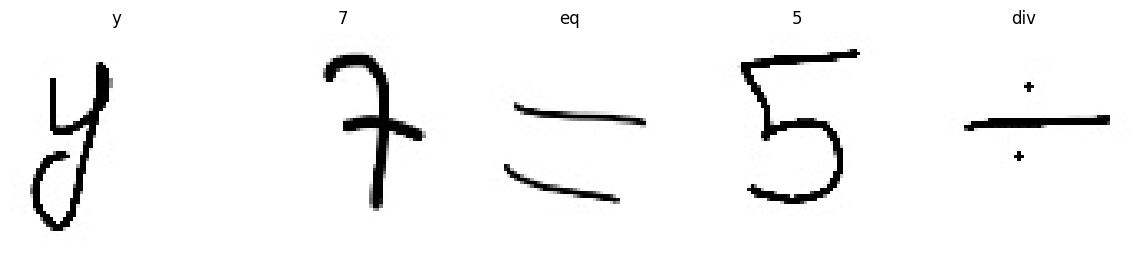


Testing image: test_image_2.jpg
Ground truth characters: ['div', 'x', 'eq']
Predicted characters: [np.str_('div'), np.str_('x'), np.str_('eq')]
Generated LaTeX: ÷ x =


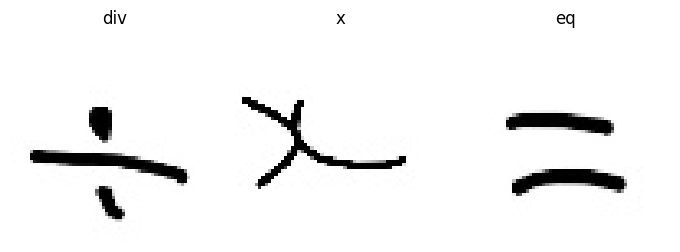


Testing image: test_image_3.jpg
Ground truth characters: ['z', '2', '8', 'x']
Predicted characters: [np.str_('z'), np.str_('2'), np.str_('8'), np.str_('x')]
Generated LaTeX: z 2 8 x


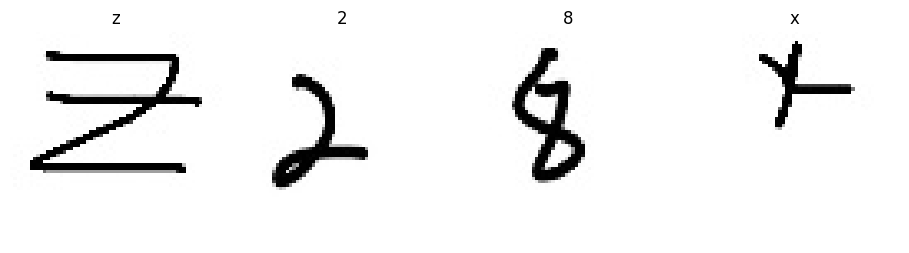


Testing image: test_image_4.jpg
Ground truth characters: ['mul', '9', 'x']
Predicted characters: [np.str_('mul'), np.str_('9'), np.str_('x')]
Generated LaTeX: × 9 x


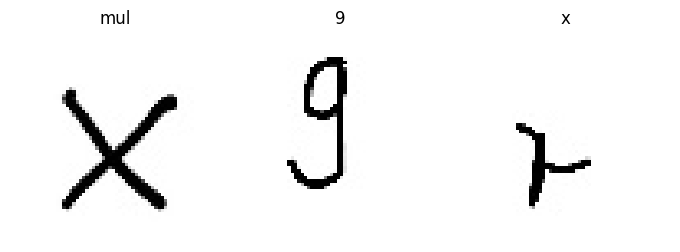


Testing image: test_image_5.jpg
Ground truth characters: ['8', 'y', '5']
Predicted characters: [np.str_('8'), np.str_('y'), np.str_('5')]
Generated LaTeX: 8 y 5


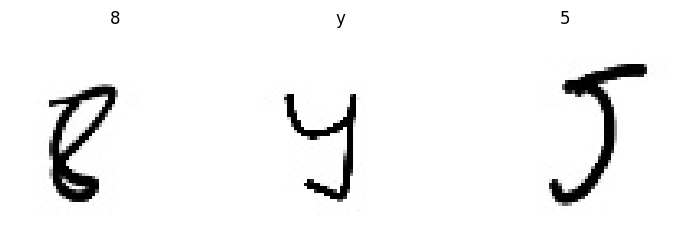


Testing image: test_image_6.jpg
Ground truth characters: ['x', '4', 'div', 'z', '3']
Predicted characters: [np.str_('x'), np.str_('4'), np.str_('div'), np.str_('z'), np.str_('3')]
Generated LaTeX: x 4 ÷ z 3


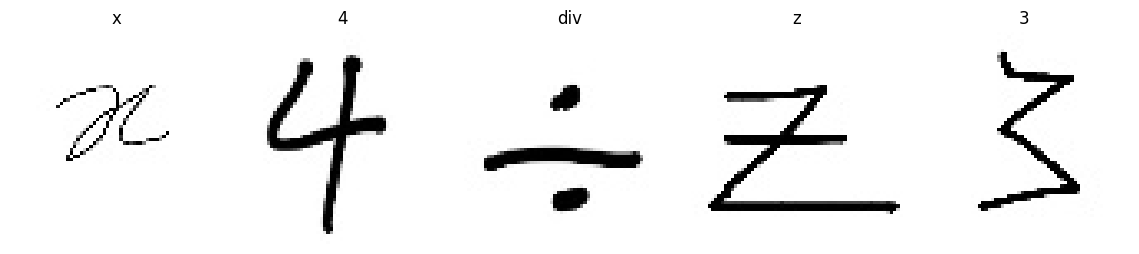


Testing image: test_image_7.jpg
Ground truth characters: ['z', 'eq', '2']
Predicted characters: [np.str_('z'), np.str_('eq'), np.str_('2')]
Generated LaTeX: z = 2


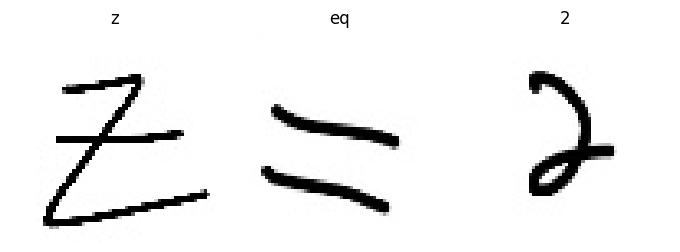


Testing image: test_image_8.jpg
Ground truth characters: ['eq', '5', 'x', '4', '9']
Predicted characters: [np.str_('eq'), np.str_('5'), np.str_('x'), np.str_('4'), np.str_('9')]
Generated LaTeX: = 5 x 4 9


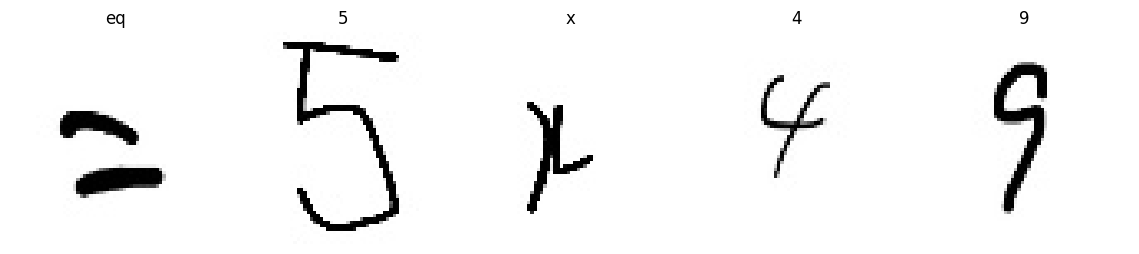


Testing image: test_image_9.jpg
Ground truth characters: ['mul', '8', '5', 'eq']
Predicted characters: [np.str_('mul'), np.str_('8'), np.str_('5'), np.str_('eq')]
Generated LaTeX: × 8 5 =


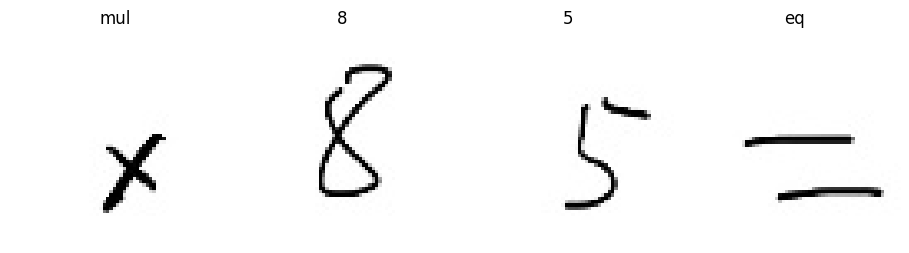


Testing image: test_image_10.jpg
Ground truth characters: ['8', '2', 'add', 'sub', '6']
Predicted characters: [np.str_('8'), np.str_('2'), np.str_('add'), np.str_('sub'), np.str_('6')]
Generated LaTeX: 8 2 + - 6


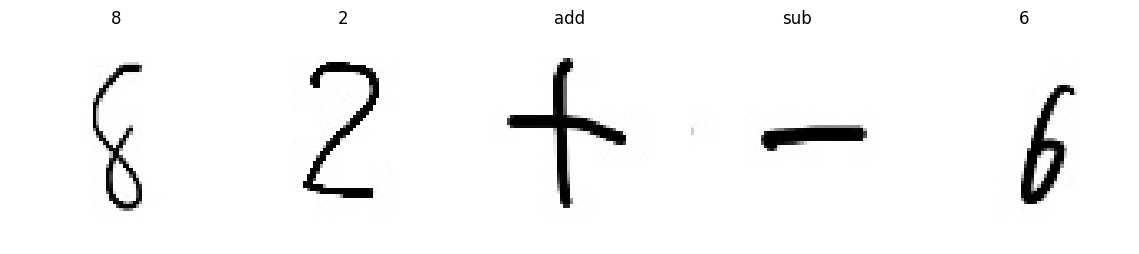


Testing image: test_image_11.jpg
Ground truth characters: ['8', 'add', '0', '1']
Predicted characters: [np.str_('8'), np.str_('add'), np.str_('9'), np.str_('1')]
Generated LaTeX: 8 + 9 1


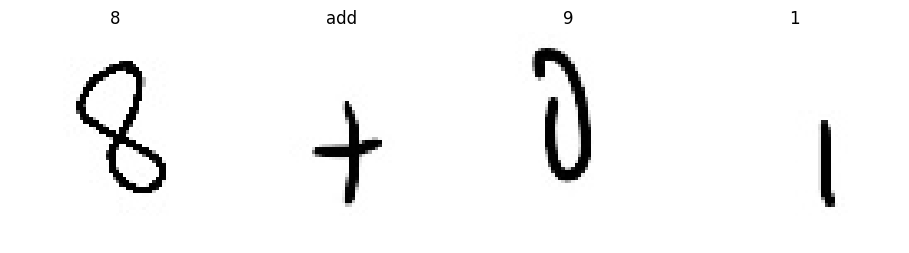


Testing image: test_image_12.jpg
Ground truth characters: ['z', 'div', '8', '6']
Predicted characters: [np.str_('z'), np.str_('div'), np.str_('y'), np.str_('6')]
Generated LaTeX: z ÷ y 6


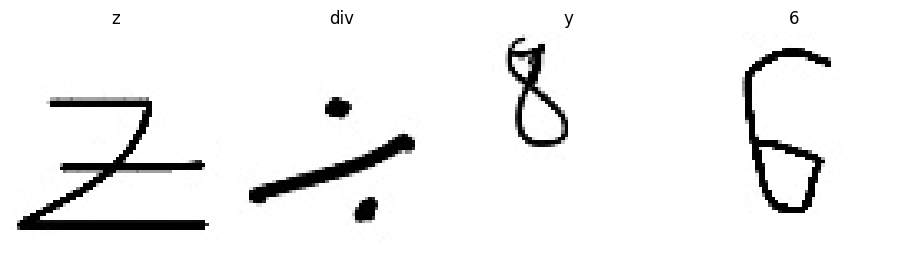


Testing image: test_image_13.jpg
Ground truth characters: ['div', 'y', '7']
Predicted characters: [np.str_('div'), np.str_('y'), np.str_('7')]
Generated LaTeX: ÷ y 7


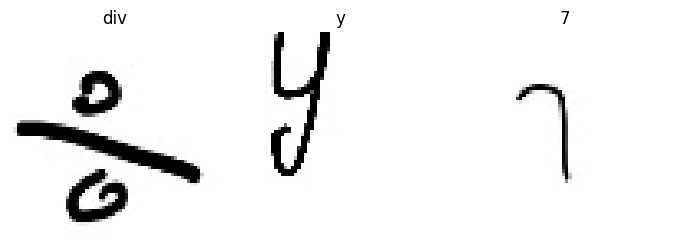


Testing image: test_image_14.jpg
Ground truth characters: ['3', '8', '0']
Predicted characters: [np.str_('x'), np.str_('8'), np.str_('0')]
Generated LaTeX: x 8 0


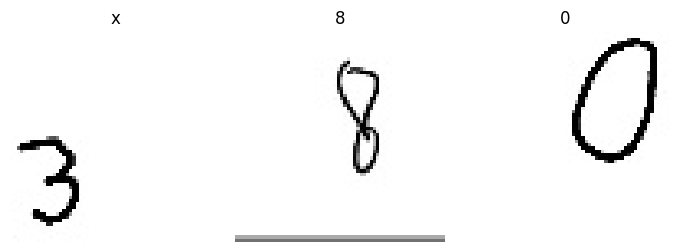


Testing image: test_image_15.jpg
Ground truth characters: ['y', '2', '4']
Predicted characters: [np.str_('y'), np.str_('2'), np.str_('4')]
Generated LaTeX: y 2 4


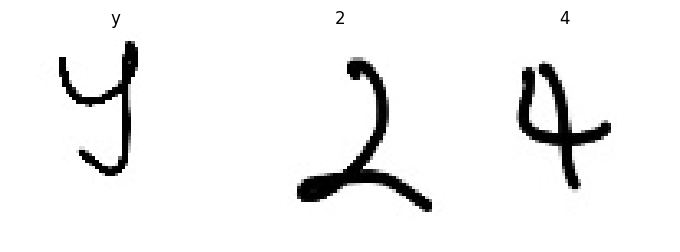


Testing image: test_image_16.jpg
Ground truth characters: ['sub', '1', '4']
Predicted characters: [np.str_('sub'), np.str_('1'), np.str_('5')]
Generated LaTeX: - 1 5


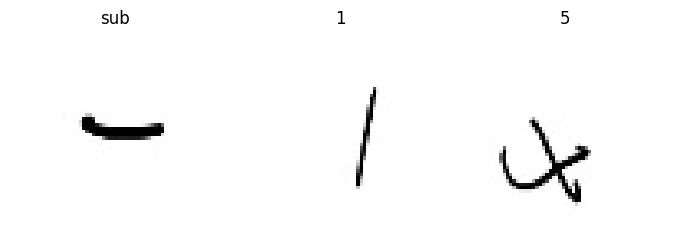


Testing image: test_image_17.jpg
Ground truth characters: ['eq', '8', 'mul', '7']
Predicted characters: [np.str_('eq'), np.str_('y'), np.str_('mul'), np.str_('7')]
Generated LaTeX: = y × 7


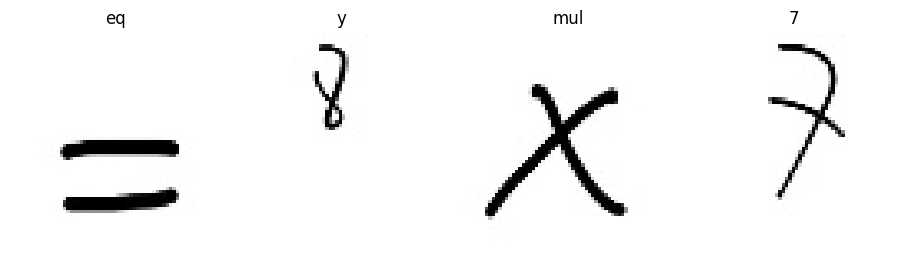


Testing image: test_image_18.jpg
Ground truth characters: ['3', '8', 'mul', 'y', '2']
Predicted characters: [np.str_('3'), np.str_('8'), np.str_('mul'), np.str_('y'), np.str_('2')]
Generated LaTeX: 3 8 × y 2


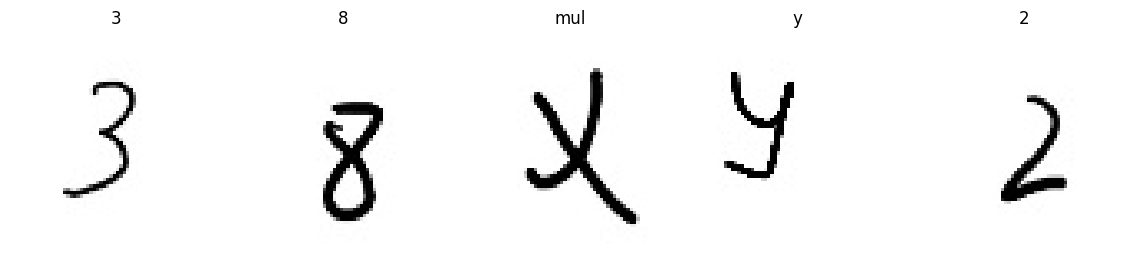


Testing image: test_image_19.jpg
Ground truth characters: ['x', 'dec', 'mul']
Predicted characters: [np.str_('x'), np.str_('dec'), np.str_('mul')]
Generated LaTeX: x . ×


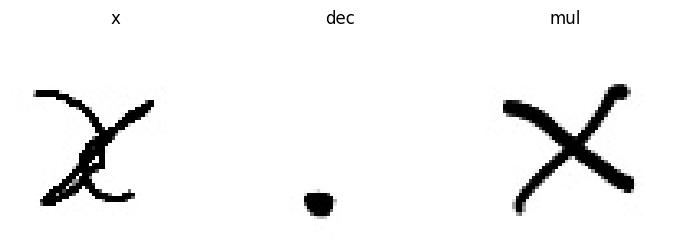


Testing image: test_image_20.jpg
Ground truth characters: ['eq', '4', 'dec', '3']
Predicted characters: [np.str_('eq'), np.str_('7'), np.str_('dec'), np.str_('3')]
Generated LaTeX: = 7 . 3


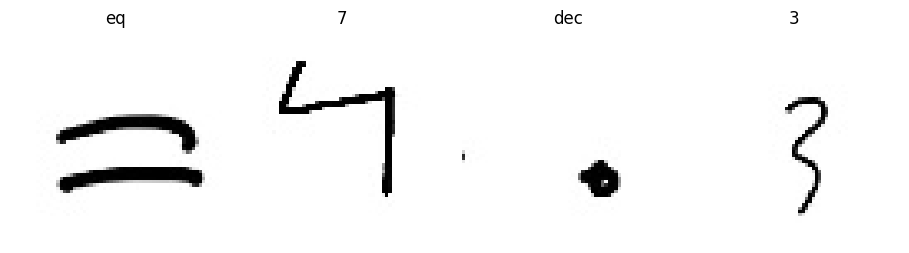


Testing image: test_image_21.jpg
Ground truth characters: ['mul', 'z', 'eq', '9', '5']
Predicted characters: [np.str_('mul'), np.str_('z'), np.str_('eq'), np.str_('9'), np.str_('5')]
Generated LaTeX: × z = 9 5


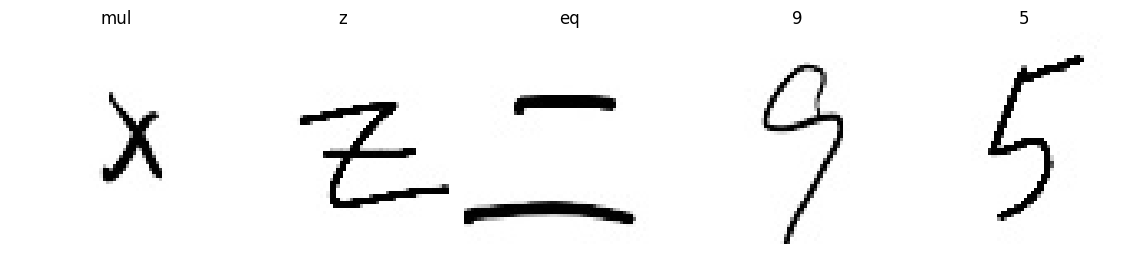


Testing image: test_image_22.jpg
Ground truth characters: ['add', '5', '9', '8']
Predicted characters: [np.str_('add'), np.str_('x'), np.str_('9'), np.str_('8')]
Generated LaTeX: + x 9 8


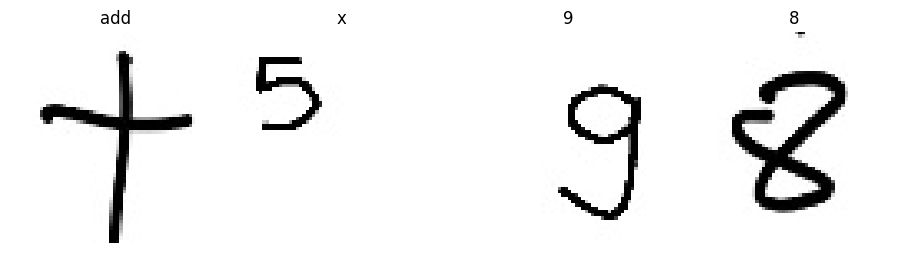


Testing image: test_image_23.jpg
Ground truth characters: ['7', 'mul', 'y', 'x', '4']
Predicted characters: [np.str_('7'), np.str_('mul'), np.str_('2'), np.str_('x'), np.str_('4')]
Generated LaTeX: 7 × 2 x 4


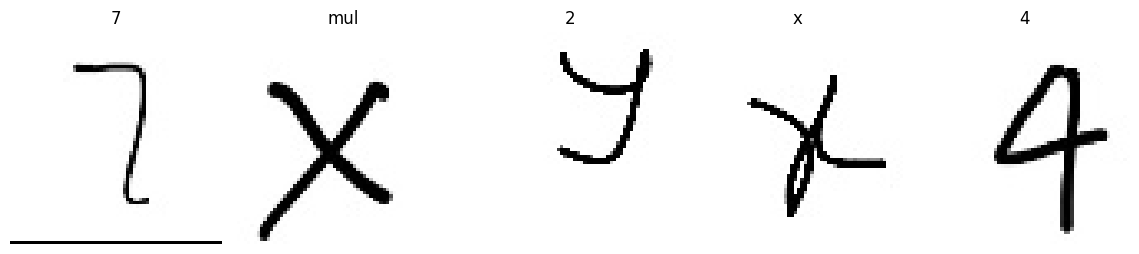


Testing image: test_image_24.jpg
Ground truth characters: ['y', '4', '8', '7']
Predicted characters: [np.str_('y'), np.str_('4'), np.str_('8'), np.str_('7')]
Generated LaTeX: y 4 8 7


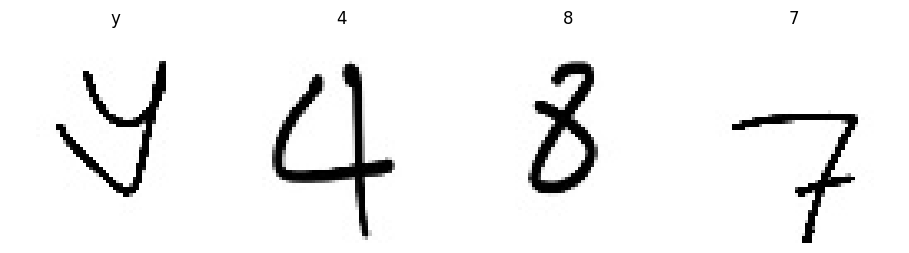


Testing image: test_image_25.jpg
Ground truth characters: ['4', '7', '2', 'y', 'sub']
Predicted characters: [np.str_('4'), np.str_('7'), np.str_('2'), np.str_('y'), np.str_('sub')]
Generated LaTeX: 4 7 2 y -


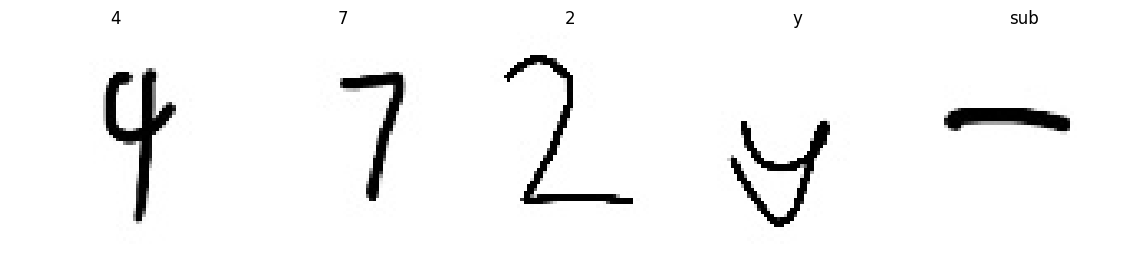


Testing image: test_image_26.jpg
Ground truth characters: ['dec', '0', '8', 'y', '6']
Predicted characters: [np.str_('6'), np.str_('3'), np.str_('3'), np.str_('y'), np.str_('6')]
Generated LaTeX: 6 3 3 y 6


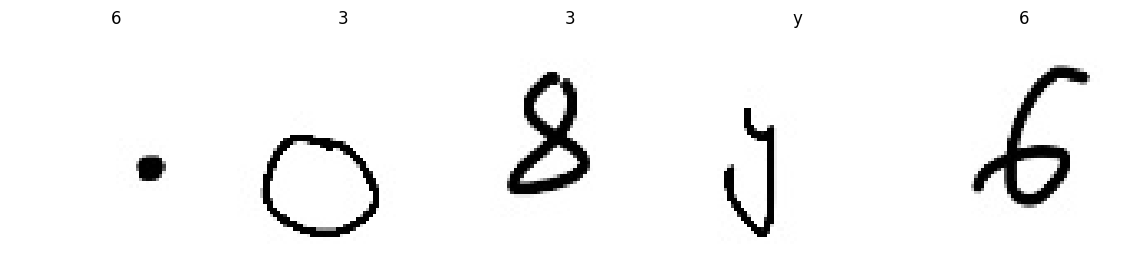


Testing image: test_image_27.jpg
Ground truth characters: ['2', '7', 'x', 'z', 'mul']
Predicted characters: [np.str_('2'), np.str_('7'), np.str_('x'), np.str_('z'), np.str_('mul')]
Generated LaTeX: 2 7 x z ×


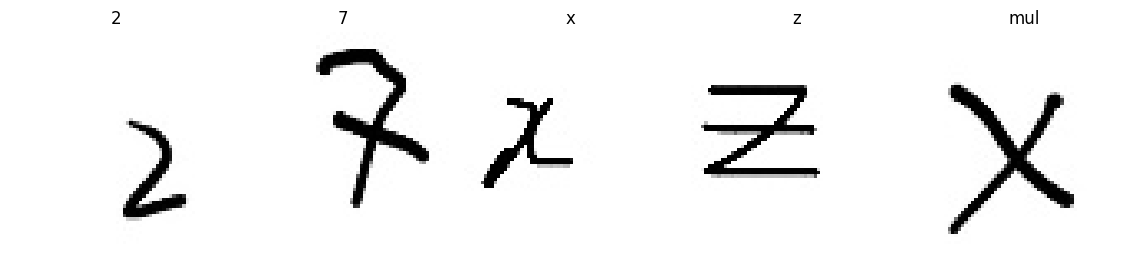


Testing image: test_image_28.jpg
Ground truth characters: ['8', 'x', '7', '4']
Predicted characters: [np.str_('8'), np.str_('x'), np.str_('7'), np.str_('4')]
Generated LaTeX: 8 x 7 4


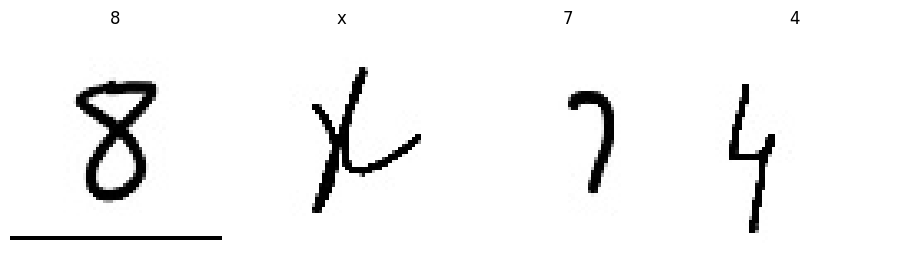


Testing image: test_image_29.jpg
Ground truth characters: ['dec', 'z', '7', 'add']
Predicted characters: [np.str_('dec'), np.str_('z'), np.str_('7'), np.str_('add')]
Generated LaTeX: . z 7 +


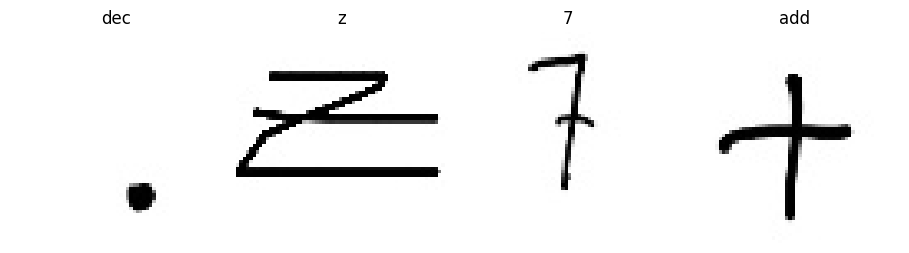


Testing image: test_image_30.jpg
Ground truth characters: ['div', 'sub', 'y']
Predicted characters: [np.str_('div'), np.str_('sub'), np.str_('y')]
Generated LaTeX: ÷ - y


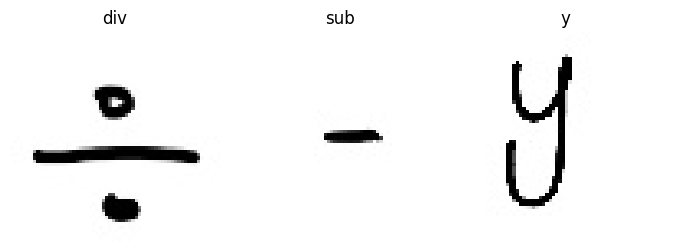


Testing image: test_image_31.jpg
Ground truth characters: ['sub', 'y', 'dec', 'div']
Predicted characters: [np.str_('sub'), np.str_('y'), np.str_('dec'), np.str_('div')]
Generated LaTeX: - y . ÷


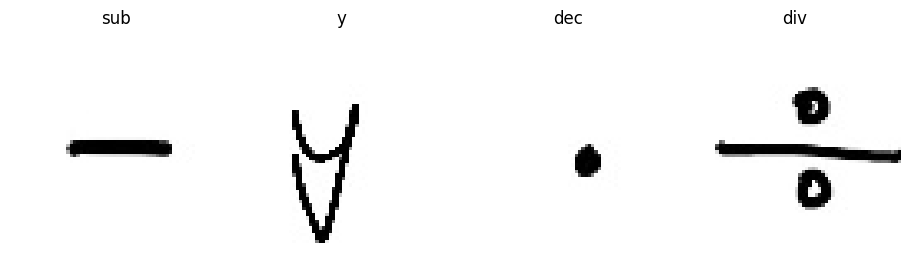


Testing image: test_image_32.jpg
Ground truth characters: ['5', 'eq', '8', '3']
Predicted characters: [np.str_('5'), np.str_('eq'), np.str_('8'), np.str_('3')]
Generated LaTeX: 5 = 8 3


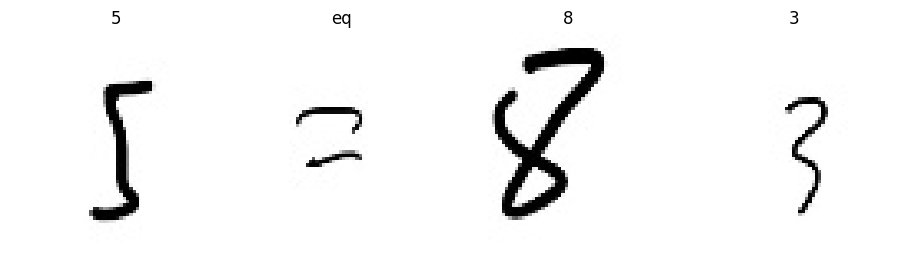


Testing image: test_image_33.jpg
Ground truth characters: ['2', 'y', 'dec', '1']
Predicted characters: [np.str_('2'), np.str_('y'), np.str_('dec'), np.str_('1')]
Generated LaTeX: 2 y . 1


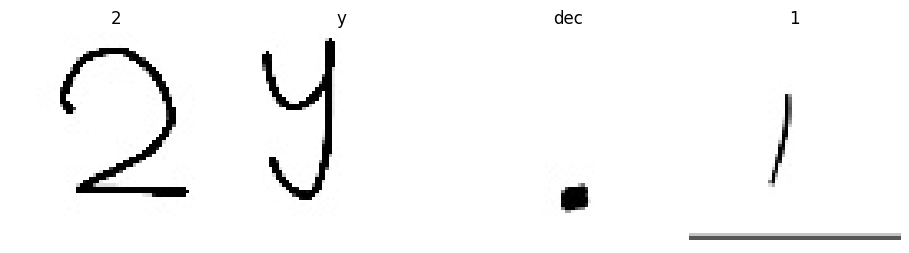


Testing image: test_image_34.jpg
Ground truth characters: ['z', 'sub', 'div', 'dec']
Predicted characters: [np.str_('z'), np.str_('sub'), np.str_('div'), np.str_('dec')]
Generated LaTeX: z - ÷ .


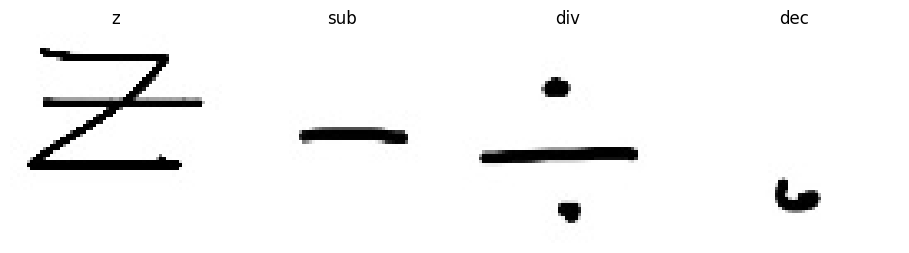


Testing image: test_image_35.jpg
Ground truth characters: ['1', 'div', '5', 'y', '4']
Predicted characters: [np.str_('1'), np.str_('div'), np.str_('5'), np.str_('y'), np.str_('4')]
Generated LaTeX: 1 ÷ 5 y 4


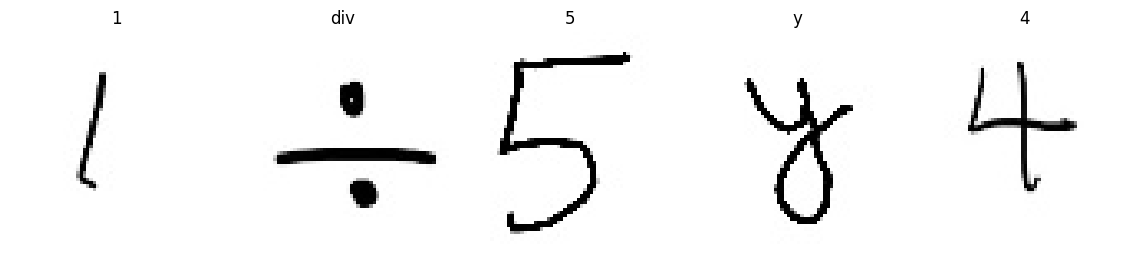


Testing image: test_image_36.jpg
Ground truth characters: ['8', 'div', 'eq']
Predicted characters: [np.str_('8'), np.str_('div'), np.str_('eq')]
Generated LaTeX: 8 ÷ =


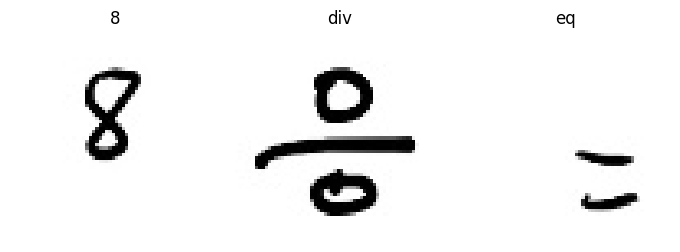


Testing image: test_image_37.jpg
Ground truth characters: ['8', '6', 'eq', '9']
Predicted characters: [np.str_('8'), np.str_('0'), np.str_('eq'), np.str_('9')]
Generated LaTeX: 8 0 = 9


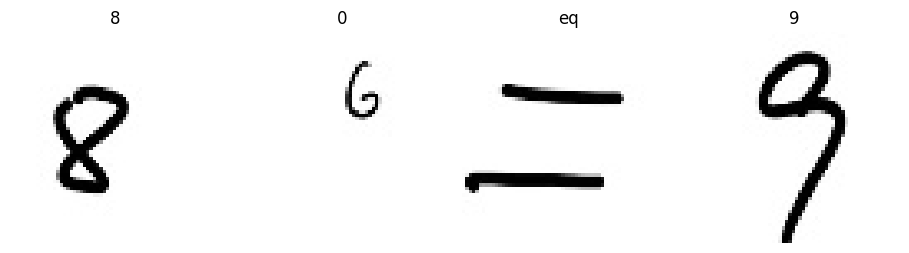


Testing image: test_image_38.jpg
Ground truth characters: ['4', 'div', '7']
Predicted characters: [np.str_('4'), np.str_('div'), np.str_('7')]
Generated LaTeX: 4 ÷ 7


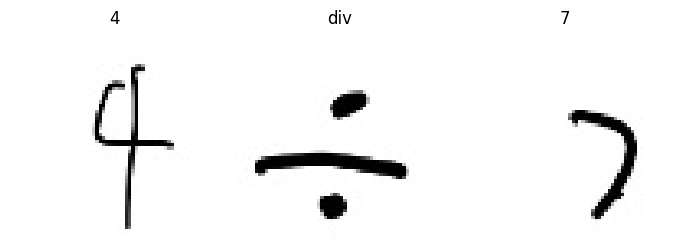


Testing image: test_image_39.jpg
Ground truth characters: ['add', 'y', '9']
Predicted characters: [np.str_('add'), np.str_('y'), np.str_('9')]
Generated LaTeX: + y 9


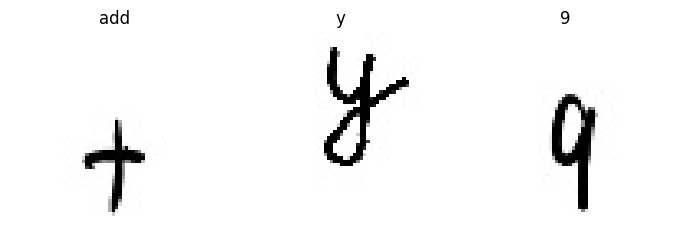


Testing image: test_image_40.jpg
Ground truth characters: ['5', 'dec', 'div', '6', 'sub']
Predicted characters: [np.str_('5'), np.str_('dec'), np.str_('div'), np.str_('0'), np.str_('sub')]
Generated LaTeX: 5 . ÷ 0 -


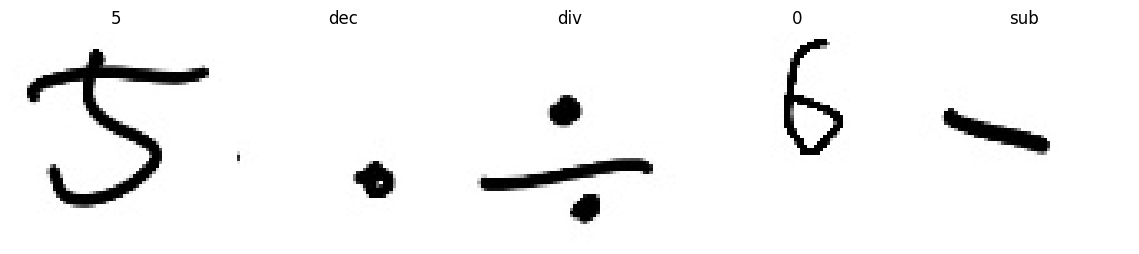


Testing image: test_image_41.jpg
Ground truth characters: ['3', '9', 'y', '7', '4']
Predicted characters: [np.str_('3'), np.str_('9'), np.str_('y'), np.str_('7'), np.str_('4')]
Generated LaTeX: 3 9 y 7 4


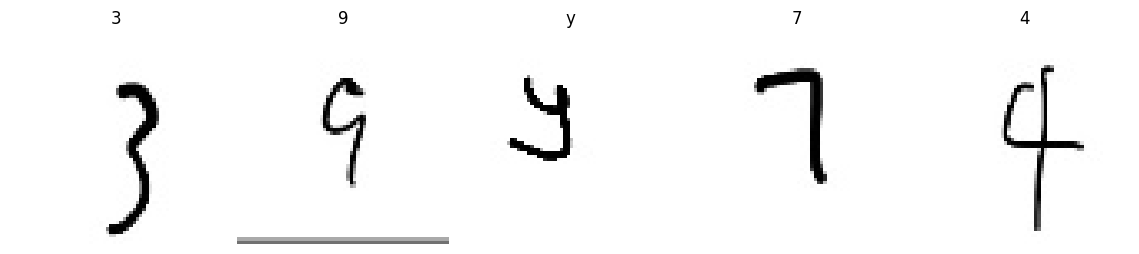


Testing image: test_image_42.jpg
Ground truth characters: ['7', 'x', '3']
Predicted characters: [np.str_('7'), np.str_('x'), np.str_('3')]
Generated LaTeX: 7 x 3


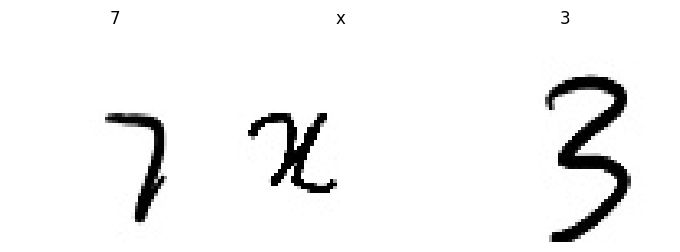


Testing image: test_image_43.jpg
Ground truth characters: ['y', 'eq', '1', '3']
Predicted characters: [np.str_('y'), np.str_('eq'), np.str_('1'), np.str_('eq')]
Generated LaTeX: y = 1 =


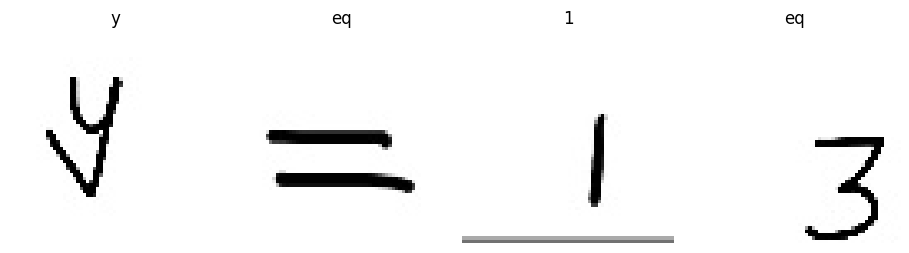


Testing image: test_image_44.jpg
Ground truth characters: ['1', 'sub', '7', 'mul']
Predicted characters: [np.str_('1'), np.str_('sub'), np.str_('7'), np.str_('mul')]
Generated LaTeX: 1 - 7 ×


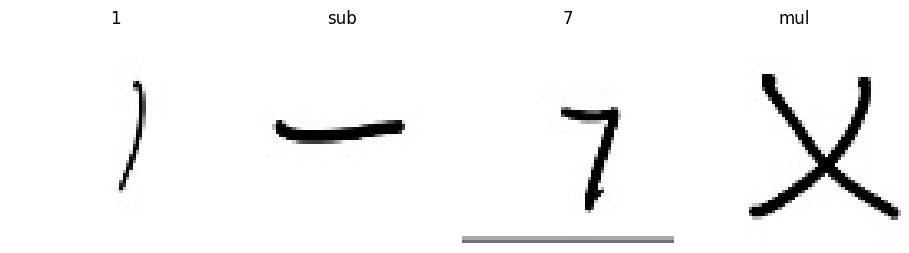


Testing image: test_image_45.jpg
Ground truth characters: ['2', 'sub', '5']
Predicted characters: [np.str_('2'), np.str_('eq'), np.str_('5')]
Generated LaTeX: 2 = 5


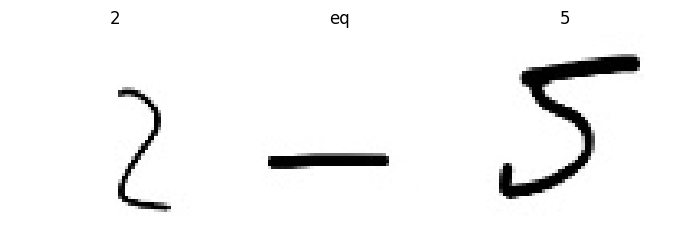


Testing image: test_image_46.jpg
Ground truth characters: ['eq', 'z', '2']
Predicted characters: [np.str_('eq'), np.str_('z'), np.str_('2')]
Generated LaTeX: = z 2


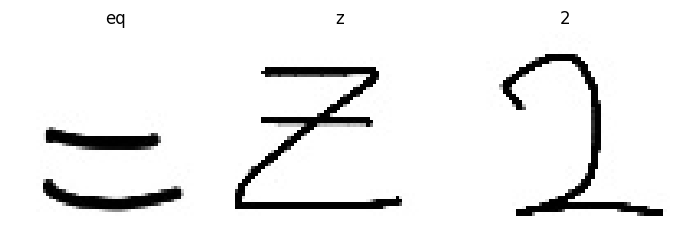


Testing image: test_image_47.jpg
Ground truth characters: ['6', '8', '1']
Predicted characters: [np.str_('6'), np.str_('8'), np.str_('1')]
Generated LaTeX: 6 8 1


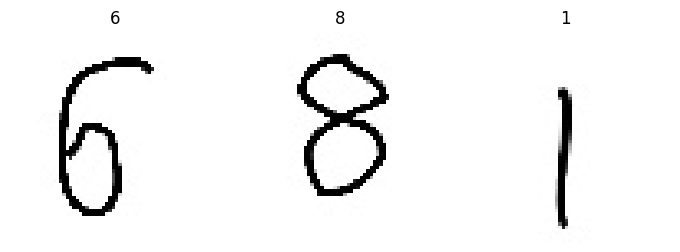


Testing image: test_image_48.jpg
Ground truth characters: ['z', '2', '7', 'sub']
Predicted characters: [np.str_('z'), np.str_('2'), np.str_('7'), np.str_('sub')]
Generated LaTeX: z 2 7 -


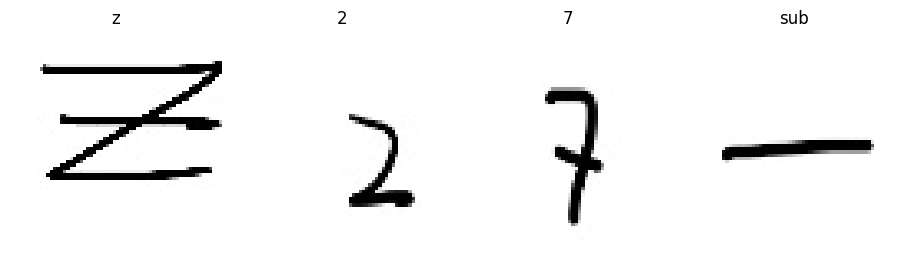


Testing image: test_image_49.jpg
Ground truth characters: ['8', 'eq', 'add', 'dec']
Predicted characters: [np.str_('8'), np.str_('eq'), np.str_('add'), np.str_('6')]
Generated LaTeX: 8 = + 6


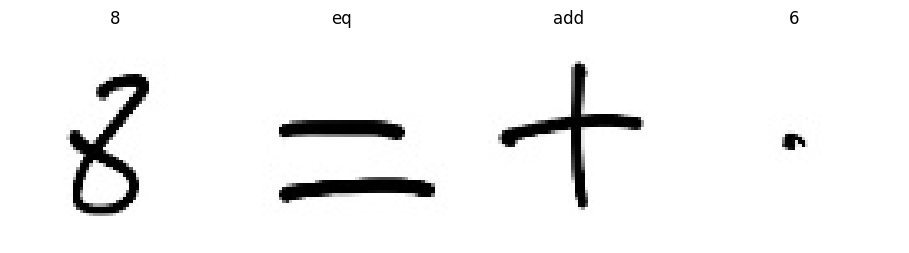


Testing image: test_image_50.jpg
Ground truth characters: ['dec', '6', 'x']
Predicted characters: [np.str_('dec'), np.str_('9'), np.str_('x')]
Generated LaTeX: . 9 x


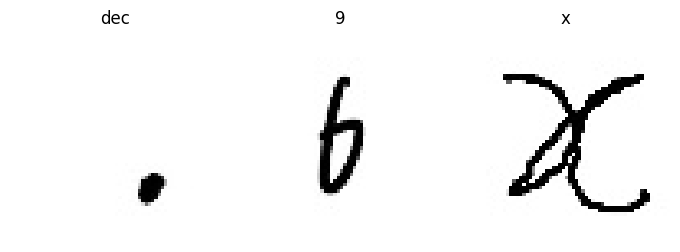

In [29]:
def test_all_images(ocr, test_images_info):
    """
    Run OCR on multiple test images, print results, and visualize predictions.
    
    Parameters:
    - ocr: An instance of AugmentedFeatureOCR class with trained classifier
    - test_images_info: Dictionary where keys are test image filenames and values are lists of ground truth symbols
    
    This function processes each test image by:
    - Segmenting the image into symbols
    - Classifying each symbol
    - Translating predictions into LaTeX format
    - Printing ground truth and predicted results
    - Visualizing the symbols with their predicted labels
    """
    
    # Iterate over each test image and its ground truth symbols
    for img_name, true_chars in test_images_info.items():
        print(f"\nTesting image: {img_name}")  # Print current test image filename
        print(f"Ground truth characters: {true_chars}")  # Print list of correct symbol classes
        
        # Segment the image into individual symbols assuming fixed-width segmentation,
        # number of segments equals number of ground truth symbols
        symbols = ocr.segment_symbols_fixed(img_name, len(true_chars))
        
        # Predict symbol classes from segmented images
        predicted = ocr.classify_symbols(symbols)
        
        # Convert predicted class labels to LaTeX string for output formatting
        latex = ocr.to_latex(predicted)
        
        print("Predicted characters:", predicted)  # Display predicted symbols
        print("Generated LaTeX:", latex)  # Display LaTeX string
        
        # Visualize the segmented symbol images with predicted class titles
        ocr.visualize_results(symbols, predicted)

# Usage example: run testing on test images stored in 'test_images_info' dictionary
test_all_images(ocr, test_images_info)


In [30]:
def evaluate_model(ocr, test_images_info):
    """
    Evaluate the OCR model's performance on a set of test images.
    
    Parameters:
    - ocr: Instance of AugmentedFeatureOCR with trained classifier
    - test_images_info: Dictionary mapping image filenames to their ground truth symbol sequences (lists)
    
    This function computes:
    - Symbol-level accuracy: percentage of individual symbols correctly predicted
    - Sequence-level accuracy: percentage of full symbol sequences exactly matched
    """

    total_symbols = 0     # Counter for total number of symbols tested across all images
    correct_symbols = 0   # Counter for total correctly predicted individual symbols

    total_sequences = 0   # Counter for total number of test images (sequences)
    correct_sequences = 0 # Counter for total number of perfectly predicted sequences

    # Iterate over each test image and its true symbol labels
    for img_name, true_chars in test_images_info.items():
        # Segment the image into symbols using fixed-width segmentation, assuming number of symbols is known
        symbols = ocr.segment_symbols_fixed(img_name, len(true_chars))

        # Use the OCR model to predict the classes of each segmented symbol image
        predicted = ocr.classify_symbols(symbols)

        # Update count of total symbols by number of symbols in this image
        total_symbols += len(true_chars)

        # Update count of correct individual symbol predictions by comparing predicted and true labels element-wise
        # sum of matches where predicted and true symbol at same position are equal
        correct_symbols += sum(p == t for p, t in zip(predicted, true_chars))

        # Update count of total sequences tested (number of images)
        total_sequences += 1

        # If the entire predicted sequence matches exactly the ground truth sequence, increment perfect match counter
        if predicted == true_chars:
            correct_sequences += 1

    # Calculate overall symbol-level accuracy as correct predictions divided by total symbols tested
    symbol_accuracy = correct_symbols / total_symbols if total_symbols > 0 else 0

    # Calculate sequence-level accuracy as perfect full sequence matches divided by total sequences
    sequence_accuracy = correct_sequences / total_sequences if total_sequences > 0 else 0

    # Print results with four decimal places for clarity
    print(f"Symbol-level accuracy: {symbol_accuracy:.4f}")
    print(f"Sequence-level (exact) accuracy: {sequence_accuracy:.4f}")

# Run this after training your model and generating your test image info dictionary
evaluate_model(ocr, test_images_info)


Symbol-level accuracy: 0.9128
Sequence-level (exact) accuracy: 0.7000
